In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import numpy as np

In [2]:
data = pd.read_csv('caso_full.csv')

In [3]:
data.columns

Index(['city', 'city_ibge_code', 'date', 'epidemiological_week',
       'estimated_population', 'estimated_population_2019', 'is_last',
       'is_repeated', 'last_available_confirmed',
       'last_available_confirmed_per_100k_inhabitants', 'last_available_date',
       'last_available_death_rate', 'last_available_deaths', 'order_for_place',
       'place_type', 'state', 'new_confirmed', 'new_deaths'],
      dtype='object')

In [4]:
mapping = {}
mapping['AC'] = "Norte"
mapping['AL'] = "Nordeste"
mapping['AM'] = "Norte"
mapping['AP'] = "Norte"
mapping['BA'] = "Nordeste"
mapping['CE'] = "Nordeste"
mapping['DF'] = "Centro Oeste"
mapping['ES'] = "Sudeste"
mapping['GO'] = "Centro Oeste"
mapping['MA'] = "Nordeste"
mapping['MG'] = "Sudeste"
mapping['MS'] = "Centro Oeste"
mapping['MT'] = "Centro Oeste"
mapping['PA'] = "Norte"
mapping['PB'] = "Nordeste"
mapping['PE'] = "Nordeste"
mapping['PI'] = "Nordeste"
mapping['PR'] = "Sul"
mapping['RJ'] = "Sudeste"
mapping['RN'] = "Nordeste"
mapping['RO'] = "Centro Oeste"
mapping['RR'] = "Norte"
mapping['RS'] = "Sul"
mapping['SC'] = "Sul"
mapping['SE'] = "Nordeste"
mapping['SP'] = "Sudeste"
mapping['TO'] = "Norte"

In [5]:
# field = "last_available_confirmed_per_100k_inhabitants"
field = "total_casos"

In [6]:
data = data[(data['city'].isnull() == False) & (data['is_repeated'] == False)]
data["total_casos"] = data["last_available_confirmed_per_100k_inhabitants"] * data["estimated_population_2019"]
columns_to_drop = ['city','place_type','last_available_confirmed',
                   'last_available_date','estimated_population',
                   'is_last','is_repeated']
data.drop(columns=columns_to_drop,inplace=True)
data['date'] = pd.to_datetime(data['date'],format='%Y-%m-%d')
data['region'] = data.apply (lambda row: mapping[row["state"]], axis=1)

In [7]:
data["state"].nunique()

27

In [8]:
data.region.unique()

array(['Norte', 'Nordeste', 'Centro Oeste', 'Sudeste', 'Sul'],
      dtype=object)

In [9]:
min_date = data["date"].min()
max_date = data["date"].max()
delta = max_date - min_date
dates = pd.date_range(start=min_date, end=max_date, freq='D')
def interpolate_mun(mun_data):
    #series = mun_data[["last_available_confirmed_per_100k_inhabitants","date","region"]]
    series = mun_data[[field,"date","region"]]
    region_ = series.iloc[0].region
    series = series.set_index("date").reindex(dates).interpolate().ffill().fillna(0)
    series["region"] = region_
    return series

In [10]:
#agg_data = data[["last_available_confirmed_per_100k_inhabitants","city_ibge_code","region","date"]].groupby("city_ibge_code").apply(lambda x: interpolate_mun(x))
agg_data = data[[field,"city_ibge_code","region","date"]].groupby("city_ibge_code").apply(lambda x: interpolate_mun(x))

In [11]:
agg_data = agg_data.reset_index()

In [12]:
agg_data.rename(columns={"level_1": "date"},inplace=True)

In [13]:
agg_data = agg_data[[field,"region","date"]].groupby(['region',"date"]).sum()

In [14]:
grouped = agg_data.reset_index().groupby("region")

In [15]:
X = np.zeros((len(grouped),delta.days + 1))
for i,(group, data_) in enumerate(grouped):
    #series = data_[["last_available_confirmed_per_100k_inhabitants","date"]]
    series = data_[[field,"date"]]
    print(i,group)
    series = series.set_index("date").reindex(dates).interpolate().ffill().fillna(0)
    X[i,:] = series.values.reshape(len(series))

0 Centro Oeste
1 Nordeste
2 Norte
3 Sudeste
4 Sul


In [16]:
data.region.unique()

array(['Norte', 'Nordeste', 'Centro Oeste', 'Sudeste', 'Sul'],
      dtype=object)

In [17]:
X.shape

(5, 591)

In [18]:
l = ["Centro Oeste","Nordeste","Norte","Sudeste","Sul"]

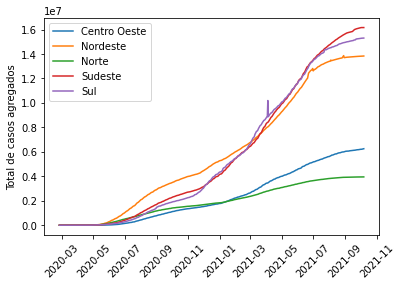

In [19]:
for i in range(5):
    plt.plot(dates,X[i,:],label=l[i])
plt.legend()
plt.ylabel("Total de casos agregados")
plt.xticks(rotation=45)
plt.show()

In [20]:
Y = np.zeros(( 5, int(np.floor(591/7)) ))
for t in range(84):
    for i in range(5):
        if t < 83:
            Y[i,t] = np.sum(X[i,7*t:7*t+7])
        else:
            Y[i,t] = np.sum(X[i,7*t:])

In [21]:
Y.shape

(5, 84)

In [22]:
#Constroi matriz de Adjacencias:
# 0 - Norte
# 1 - Centro Oeste
# 2 - Nordeste
# 3 - Sudeste
# 4 - Sul

In [23]:
A = np.zeros((5,5))

In [24]:
A[0,0] = A[0,1] = A[0,2] = A[1,0] = A[2,0] = 1
A[1,1] = A[1,2] = A[1,3] = A[1,4] = A[2,1] = A[3,1] = A[4,1] = 1
A[2,2] = A[2,3] = A[3,2] = 1
A[3,3] = A[3,4] = A[4,3] = 1
A[4,4] = 1

In [25]:
np.allclose(A,A.T)

True

In [26]:
n = 1
k = 3

In [27]:
shape = Y.shape
# shape[1] -= n
Y_hat = cp.Variable(shape)
C = cp.Variable((shape[0],k))
constraints = []
for i in range(shape[0]):
    for t in range(shape[1]-n):
        terms = []
        for l in range(min(t,k)):
            for j in range(5):
                terms.append(C[j,l]*A[i,j]*Y[j,t-l])
        constraints += [Y_hat[i,t+n] == cp.sum(terms)]

In [28]:
lambda_ = 100
obj = cp.Minimize(cp.sum_squares(Y_hat[:,n:] - Y[:,n:]) + lambda_*cp.norm1(C))
p = cp.Problem(obj,constraints)
p.solve(verbose=True,max_iter=100000)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Jul 18 12:18:49 PM: Your problem has 435 variables, 415 constraints, and 0 parameters.
(CVXPY) Jul 18 12:18:50 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 18 12:18:50 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 18 12:18:50 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 18 12:18:50 PM: Compiling problem (target solver=OSQP).
(CVXPY) Jul 18 12:18:50 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuff

8722853668167820.0

In [29]:
min_date

Timestamp('2020-02-25 00:00:00')

In [30]:
max_date

Timestamp('2021-10-07 00:00:00')